# Let's create a clean DEM for the Adventdalen to Bjørndalen area

In [1]:
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import geopandas as gpd

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('terrain')
terrain_truncated = truncate_colormap(cmap, 0.3, .9)

From https://data.npolar.no/dataset/dce53a47-c726-4845-85c3-a65b46fe2fea

I identified 2 DEM files, I check their resolution:

In [15]:
DEM1 = rxr.open_rasterio('/home/clc/Desktop/AGF350_data/svalbard_DEM/DEM1-NP_S0_DTM2_5_2009_13835_33_Longyearbyenomr/S0_DTM2_5_2009_13835_33_Longyearbyenomr.tif').squeeze() 
# Bjorndalen missing, but 2.5m DEM
DEM2 = rxr.open_rasterio('/home/clc/Desktop/AGF350_data/svalbard_DEM/DEM2-NP_S0_DTM5_2011_25162_33/S0_DTM5_2011_25162_33.tif').squeeze()

print('Resoluttions of DEM1 (x, y): ')
print(np.unique(np.diff(DEM1.x.data)))
print(np.unique(np.diff(DEM1.y.data)))
print('Resoluttions of DEM2 (x, y): ')
print(np.unique(np.diff(DEM2.x.data)))
print(np.unique(np.diff(DEM2.y.data)))

DEM1 = DEM1.rio.reproject('EPSG:4326')
DEM2 = DEM2.rio.reproject('EPSG:4326')

DEM2 = DEM2.rio.clip_box(
    minx=15.2,
    miny=78.15,
    maxx=16.2,
    maxy=78.4,
)

DEM1 = DEM1.where(DEM1>-100).where(DEM1<10000)
DEM2 = DEM2.where(DEM2>-100).where(DEM2<10000)

Resoluttions of DEM1 (x, y): 
[2.5]
[-2.5]
Resoluttions of DEM2 (x, y): 
[5.]
[-5.]


## What do they look like?

(15.2, 16.2)

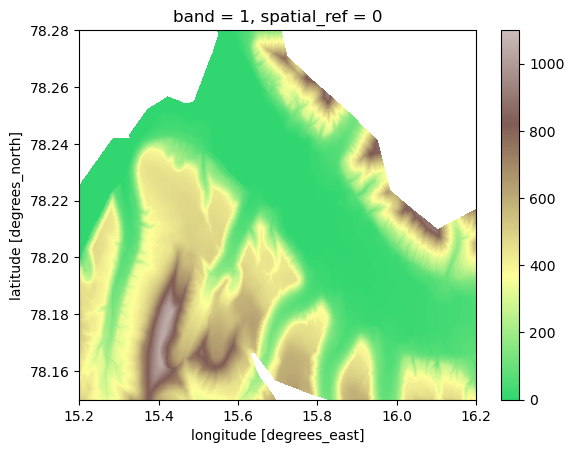

In [4]:
fig,ax = plt.subplots()
DEM1.plot(ax=ax, cmap=terrain_truncated, vmin=0, vmax=1100)
DEM2.plot(ax=ax, cmap=terrain_truncated, vmin=0, vmax=1100, add_colorbar=False)
ax.set_ylim(78.15, 78.28)
ax.set_xlim(15.2, 16.2)


In [5]:
print('lon min,              lon max,             lat min,             lat max')
[[ds.x.data.min(), ds.x.data.max(), ds.y.data.min(), ds.y.data.max()] for ds in [DEM1, DEM2]]

lon min,              lon max,             lat min,             lat max


[[15.319334302946466, 16.33350332815077, 78.13604547142502, 78.328326480353],
 [15.20005786027501, 16.199945783299885, 78.14991248899824, 78.24226939339269]]

> **The two files have different resolutions**

In [6]:
print('lon min,              lon max,             lat min,             lat max')
[[np.unique(np.diff(ds.x.data)), np.unique(np.diff(ds.y.data))] for ds in [DEM1, DEM2]]

lon min,              lon max,             lat min,             lat max


[[array([8.09263506e-05, 8.09263506e-05, 8.09263506e-05]),
  array([-8.09263506e-05, -8.09263505e-05])],
 [array([0.00018435, 0.00018435, 0.00018435]),
  array([-0.00018435, -0.00018435])]]

# Let's interpolate the low-res DEM on the high-res grid

I want to use rioxarray's reproject_match function. For that, I first need to increase the extent of DEM1 such that is spans further west, including Bjørndalen. 

DEM1 has a resolution of 2.5m, and it needs to be expanded about 2.5km to the west, so let's add 1000 cells to the left.

In [7]:
n_new_columns = 1000

# Calculate the spacing between x coordinates
x_spacing = DEM1.x[1] - DEM1.x[0]

# Create new x-coordinates for the additional columns
new_x_coords = np.arange(DEM1.x[0] - n_new_columns * x_spacing, DEM1.x[0], x_spacing)

# Create a DataArray for the new columns, filled with NaN
new_columns = xr.DataArray(
    data=np.full((DEM1.shape[0], n_new_columns), np.nan),  # Shape: (y, x_new)
    dims=["y", "x"],
    coords={
        "y": DEM1.y,                 # Keep the same y-coordinates
        "x": new_x_coords            # Add the new x-coordinates
    },
    attrs=DEM1.attrs                # Use the same attributes as the original
)

# Concatenate the new columns to the original DataArray
expanded_DEM1 = xr.concat([new_columns, DEM1], dim="x")

/home/clc/micromamba/envs/rxr/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


### Reproject DEM2 onto the expanded DEM1

In [8]:
DEM2interpolated = DEM2.rio.reproject_match(expanded_DEM1)

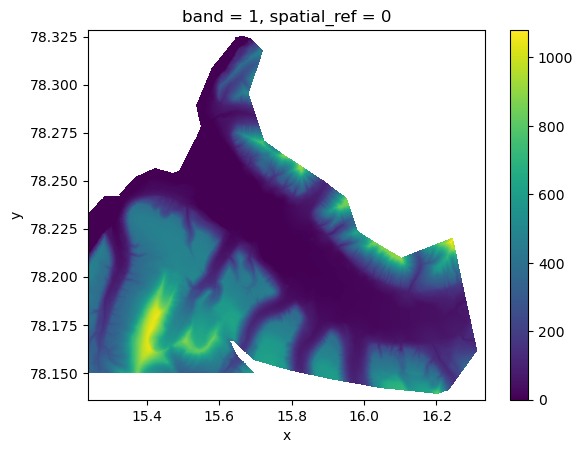

In [9]:
DEM_f = xr.where(np.isnan(expanded_DEM1), DEM2interpolated, expanded_DEM1)
DEM_f = DEM_f.where(DEM_f>-100).where(DEM_f<10000)
DEM_f.plot()

## Brilliant! Save it

In [10]:
DEM_f.rio.to_raster('/home/clc/Desktop/DEM_AGF350.tif')